In [27]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from functions.datasets import CocoDetectionWithFilenames

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [28]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = CocoDetectionWithFilenames(
    root=os.path.join("data", "images"), 
    annFile=os.path.join("data", "coco_annotations.json"), 
    transform=transform
)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
num_workers = os.cpu_count()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
cuda


In [14]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = self._initialize_fc1()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._run_first_layers(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

    def _initialize_fc1(self) -> nn.Linear:
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 200)
            x = self._run_first_layers(dummy_input)
            input_size = x.size(1)
            
            return nn.Linear(input_size, 128)
        
    def _run_first_layers(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        return x

In [15]:
def extract_bboxes(targets: list[dict]) -> list[torch.Tensor]:
    bboxes = []
    
    for target in targets:
        xs, ys, widths, heights = target["bbox"]
    
        for idx, _ in enumerate(xs):
            x1, y1, width, height = xs[idx], ys[idx], widths[idx], heights[idx]
            # Convert COCO format (x, y, width, height) to (x1, y1, x2, y2)
            x2, y2 = x1 + width, y1 + height
    
            bboxes.append(torch.IntTensor([x1, y1, x2, y2]))

    return bboxes


model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()
            
            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=18.5] 


Epoch 1, Loss: 18.521537538008257


Epoch 1/25 - Validation: 100%|██████████| 47/47 [00:46<00:00,  1.02it/s, Val Loss=10.6]


Validation Loss: 10.552981051992862


Epoch 2/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.51it/s, Train Loss=10.4]  


Epoch 2, Loss: 10.382498448545283


Epoch 2/25 - Validation: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s, Val Loss=10.6]


Validation Loss: 10.634013033927754


Epoch 3/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.54it/s, Train Loss=8.92]  


Epoch 3, Loss: 8.921813758936795


Epoch 3/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=9.3] 


Validation Loss: 9.302984623198814


Epoch 4/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.52it/s, Train Loss=8.47]  


Epoch 4, Loss: 8.4671715519645


Epoch 4/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Val Loss=8.06]


Validation Loss: 8.061620306461416


Epoch 5/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=8.13]  


Epoch 5, Loss: 8.131578614495018


Epoch 5/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=8.43]


Validation Loss: 8.43319174583922


Epoch 6/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.43it/s, Train Loss=7.89]  


Epoch 6, Loss: 7.88743596943942


Epoch 6/25 - Validation: 100%|██████████| 47/47 [00:45<00:00,  1.03it/s, Val Loss=8.84]


Validation Loss: 8.836701717782528


Epoch 7/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.52it/s, Train Loss=7.67]  


Epoch 7, Loss: 7.671473678675565


Epoch 7/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Val Loss=8.09]


Validation Loss: 8.093115218142247


Epoch 8/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=7.49]  


Epoch 8, Loss: 7.492988909374584


Epoch 8/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Val Loss=10.9]


Validation Loss: 10.861517236587849


Epoch 9/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.47it/s, Train Loss=7.51]  


Epoch 9, Loss: 7.5127035390247


Epoch 9/25 - Validation: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s, Val Loss=6.99]


Validation Loss: 6.991475429940731


Epoch 10/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=7]     


Epoch 10, Loss: 6.9980673703280365


Epoch 10/25 - Validation: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s, Val Loss=7.21]


Validation Loss: 7.209174480844052


Epoch 11/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.50it/s, Train Loss=6.97]  


Epoch 11, Loss: 6.9661302707412025


Epoch 11/25 - Validation: 100%|██████████| 47/47 [00:45<00:00,  1.03it/s, Val Loss=7.39]


Validation Loss: 7.3852989927251285


Epoch 12/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=7.02]  


Epoch 12, Loss: 7.015096428177573


Epoch 12/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Val Loss=9.59]


Validation Loss: 9.585002716551436


Epoch 13/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.51it/s, Train Loss=6.82]  


Epoch 13, Loss: 6.819957408038053


Epoch 13/25 - Validation: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s, Val Loss=7.26]


Validation Loss: 7.264607754159481


Epoch 14/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.47it/s, Train Loss=6.72]  


Epoch 14, Loss: 6.722924176129427


Epoch 14/25 - Validation: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s, Val Loss=7.04]


Validation Loss: 7.043954991279764


Epoch 15/25 - Training: 100%|██████████| 220/220 [00:52<00:00,  4.17it/s, Train Loss=6.52]  


Epoch 15, Loss: 6.51542154008692


Epoch 15/25 - Validation: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s, Val Loss=6.55]


Validation Loss: 6.547439402722298


Epoch 16/25 - Training: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s, Train Loss=6.76]  


Epoch 16, Loss: 6.758858234232123


Epoch 16/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=7.39]


Validation Loss: 7.392807503964039


Epoch 17/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=6.4]   


Epoch 17, Loss: 6.396540895375338


Epoch 17/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.07it/s, Val Loss=7.05]


Validation Loss: 7.0547826239403255


Epoch 18/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.55it/s, Train Loss=6.44]  


Epoch 18, Loss: 6.4438860719854185


Epoch 18/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.07it/s, Val Loss=6.98]


Validation Loss: 6.97978261176576


Epoch 19/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.55it/s, Train Loss=6.3]   


Epoch 19, Loss: 6.295994289354844


Epoch 19/25 - Validation: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s, Val Loss=6.49]


Validation Loss: 6.490070758981908


Epoch 20/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.53it/s, Train Loss=6.23]  


Epoch 20, Loss: 6.233892892707478


Epoch 20/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Val Loss=6.43]


Validation Loss: 6.433213852821512


Epoch 21/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.48it/s, Train Loss=6.3]   


Epoch 21, Loss: 6.29629481272264


Epoch 21/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=6.6] 


Validation Loss: 6.602298462644536


Epoch 22/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.51it/s, Train Loss=6.21]  


Epoch 22, Loss: 6.2105201428586785


Epoch 22/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=6.53]


Validation Loss: 6.534119575581652


Epoch 23/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.51it/s, Train Loss=6.09]  


Epoch 23, Loss: 6.086889339577068


Epoch 23/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=7.85]


Validation Loss: 7.847876193675589


Epoch 24/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.41it/s, Train Loss=6.14]  


Epoch 24, Loss: 6.138635038245808


Epoch 24/25 - Validation: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s, Val Loss=6.3] 


Validation Loss: 6.301226037613889


Epoch 25/25 - Training: 100%|██████████| 220/220 [00:49<00:00,  4.40it/s, Train Loss=5.98]  


Epoch 25, Loss: 5.984524158997969


Epoch 25/25 - Validation: 100%|██████████| 47/47 [00:44<00:00,  1.06it/s, Val Loss=6.7] 

Validation Loss: 6.70321979928524
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

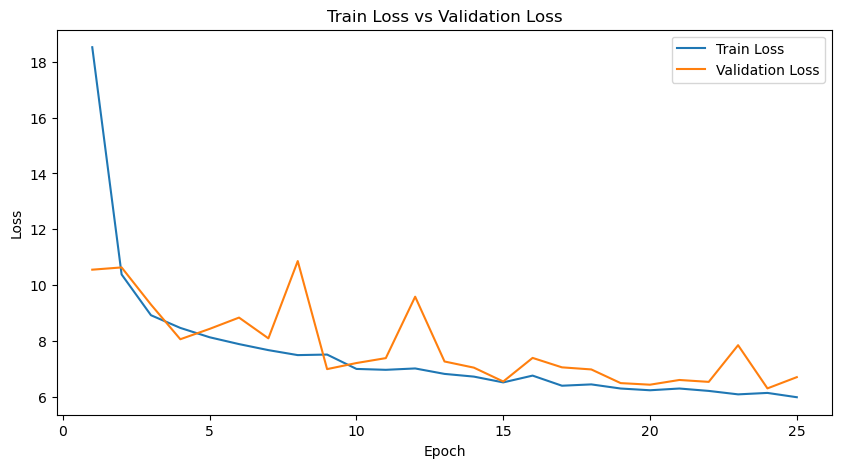

In [17]:
plt.figure(figsize=(10, 5))

epochs = range(1, num_epochs + 1)

sns.lineplot(x=epochs, y=train_losses, label="Train Loss")
sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

In [18]:
model.eval()
test_loss = 0.0
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in test_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)
        outputs = model(images)
        loss = criterion(outputs, bboxes)
        test_loss += loss.item()

        test_loader_tqdm.set_postfix({"Test Loss": test_loss / len(test_loader)})

test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s, Test Loss=6.91]

Test Loss: 6.905514311283193


In [29]:
def draw_bounding_boxes(image: Image.Image, box: tuple[int, int, int, int]) -> Image.Image:
    draw = ImageDraw.Draw(image)
    
    draw.rectangle(box, outline="black", width=2)
        
    return image

def save_images_with_bboxes() -> None:
    output_dir = os.path.join("data", "1_basic_output_imgs")
    
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for idx, (images, targets) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)

            for i in range(images.size(0)):
                image_tensor = images[i].cpu()
                image = to_pil_image(image_tensor)
                filename = dataset.get_filename(idx * images.size(0) + i)
                predicted_box = outputs[i].cpu().tolist()
                predicted_box = [int(num) for num in predicted_box]
                image_with_box = draw_bounding_boxes(image, predicted_box)

                image_with_box.save(os.path.join(output_dir, filename))

        print(f"Images with bounding boxes have been saved to {output_dir}")

save_images_with_bboxes()

Images with bounding boxes have been saved to data\1_basic_output_imgs
